# **DQN vs PPO: Practical Implementations**
***Authors: Bram Silue, Prof. dr. Pieter Libin, Prof. dr. Niel Hens.***

Previously, we developed a Deep Q-Network (DQN) from scratch to understand the foundational aspects of reinforcement learning algorithms. In practice, however, developers often leverage well-optimized, **pre-built libraries** instead. 

In this notebook, we will use the Stable Baselines library to implement two of the most significant reinforcement learning algorithms: Deep Q-Network (DQN) and Proximal Policy Optimization (PPO). We will train these algorithms on the Lunar Lander environment from Gymnasium. The implementation we will follow is based on the Stable Baselines [documentation](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html).

### **Implementing DQN**
Stable-baselines allows for very straightforward usage of advanced reinforcemente learning algorithms. Let's start with DQN.

First, we import the necessary libraries.

In [1]:
# Environment.
import gymnasium as gym

# Machine Learning.
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

# Plotting.
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Numerical computing.
import numpy as np

Next, we create the environment.

In [2]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

Next, we create the DQN agent.

In [3]:
learning_rate = 2e-3
model = DQN(policy='MlpPolicy', 
            env=env, 
            learning_rate=learning_rate)

Before training the agent, we write a Callback object that will retrieve the rewards during training so that we can plot the learning curve.

In [4]:
class LogAndSave_Callback(BaseCallback):
    """
    A custom callback for stable_baselines3 to log cumulative rewards per episode
    and save the best model so far.

    Arguments
    ----------
    save_path :  The file path to save the best model.
    verbose   :  The verbosity level; 0 means silent, higher values increase verbosity.

    """
    def __init__(self, 
                 save_path: str, 
                 verbose: int = 0) -> None:
        """
        Initializes the RewardLoggerCallback instance.

        Arguments
        ---------
        verbose :  Sets the verbosity level; defaults to 0 (silent).

        """
        super(LogAndSave_Callback, self).__init__(verbose)
        self.save_path = save_path

        # Initialize reward logging
        self.all_episode_rewards = []     # list of cumulative rewards, for all episodes.
        self.episode_rewards = 0          # cumulative reward a single episode, initialized at 0.
        self.best_rewards = -float('inf')  # the best reward seen so far, initialized at -inf.

    def _on_step(self) -> bool:
        """
        Executed at each step of the episode to log rewards and reset counters when an episode ends.

        Returns
        -------
        Always returns True to continue training.

        """
        # Accumulate the rewards.
        self.episode_rewards += self.locals['rewards'].item()

        if self.locals['dones']:
            # Log the episode's total reward.
            self.all_episode_rewards.append(self.episode_rewards)
            
            # Save the model if it performs well.
            if self.episode_rewards > 0.9 * self.best_rewards:
                self.model.save(self.save_path)
            
            # Update the best reward.
            if self.episode_rewards > self.best_rewards:
                self.best_rewards = self.episode_rewards

            # Reset accumulated rewards for the next episode.
            self.episode_rewards = 0

        # Return True to continue training.
        return True

Now, we train the DQN agent we just created.

In [5]:
# Set the arguments.
timesteps = 600_000
callback = LogAndSave_Callback(save_path='trained/dqn.pth')

# Train the model.
model.learn(total_timesteps=timesteps, 
            callback=callback)

We can now load the trained DQN model and evaluate it.

In [6]:
# Load the model.
model = DQN.load('trained/dqn.pth', env=env)

# Evaluate the model.
mean_reward, std_reward = evaluate_policy(model=model, 
                                          env=model.get_env(), 
                                          n_eval_episodes=10)
print(f'Mean reward: {mean_reward:.2f} ± {std_reward:.2f}')

Mean reward: 187.44 ± 57.58


Let's also write a plotting function and plot the learning curve.

In [7]:
def plot_learning_curve(model: DQN | PPO,
                        rewards: list, 
                        window_length: int = 15, 
                        polyorder: int = 3) -> None:
    """
    Plots a smoothed learning curve for cumulative rewards from a list.

    Arguments
    ---------
    rewards       :  The list of cumulative rewards per episode.
    window_length :  The length of the filter window.
    polyorder     :  The order of the polynomial used to fit the samples.

    """
    # Convert the rewards list to a numpy array for easier manipulation.
    rewards_array = np.array(rewards)

    # Apply Savitzky-Golay filter to smooth the rewards.
    if len(rewards_array) >= window_length:
        smoothed_rewards = savgol_filter(rewards_array, 
                                         window_length=window_length, 
                                         polyorder=polyorder)
    else:
        # If the data is less than the window length, do not smooth.
        smoothed_rewards = rewards_array

    # Create a new figure for the plot.
    plt.figure()

    # Plot the smoothed cumulative rewards.
    plt.plot(smoothed_rewards, label='Smoothed Cumulative Reward', 
             linewidth=1, color='blue')

    # Configure plot labels and legend.
    plt.xlabel('Episode', fontweight='bold')
    plt.ylabel('Cumulative Reward', fontweight='bold')
    plt.title(f'{model.__class__.__name__}: Smoothed Learning Curve', 
              fontweight='bold')
    plt.legend()
    plt.show()

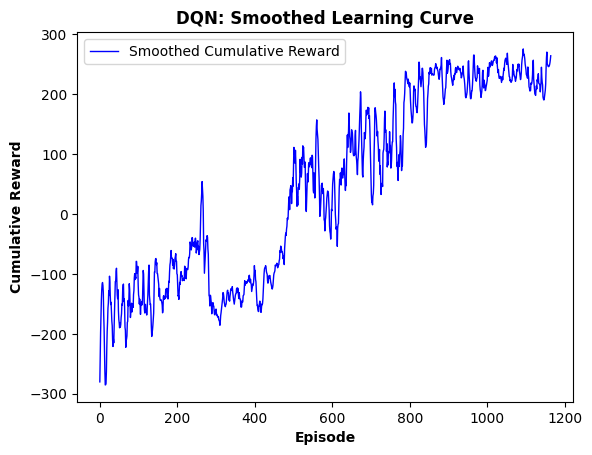

In [8]:
plot_learning_curve(model, rewards=callback.all_episode_rewards)

Finally, we can visualize the policy of our trained DQN model, for fun.

In [9]:
def visualize_policy(model: DQN | PPO, num_episodes: int = 3) -> None:
    """
    Visualizes the policy of a given model via a 2D animation.

    Arguments
    ---------
    model :  The model (DQN or PPO).
    
    """
    # Setup the environment.
    vec_env = model.get_env()
    obs = vec_env.reset()

    # Track the number of episodes simulated so far.
    episodes_done = 0

    # Simulate episodes.
    while episodes_done < num_episodes:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action)
        vec_env.render('human')

        if dones:
            episodes_done += 1
            obs = vec_env.reset()


In [10]:
visualize_policy(model)

### **Implementing PPO**

We will now use the PPO algorithm from the Stable Baselines library. The approach is analogous to what we did earlier with DQN.

First, we instantiate the environment.

In [11]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

Next, we create the PPO agent.

In [12]:
model = PPO(policy='MlpPolicy', 
            env=env, 
            learning_rate=learning_rate)

Next, we train the PPO agent we just created.

In [13]:
# Set the arguments.
timesteps = 600_000
callback = LogAndSave_Callback(save_path='trained/ppo.pth')

# Train the model.
model.learn(total_timesteps=timesteps, 
            callback=callback)

We can now evaluate the PPO agent.

In [14]:
# Load the model.
model = PPO.load('trained/ppo.pth', env=env)

# Evaluate the model.
mean_reward, std_reward = evaluate_policy(model=model, 
                                          env=model.get_env(), 
                                          n_eval_episodes=10)
print(f'Mean reward: {mean_reward:.2f} ± {std_reward:.2f}')

Mean reward: 242.66 ± 45.78


Let's also plot the learning curve.

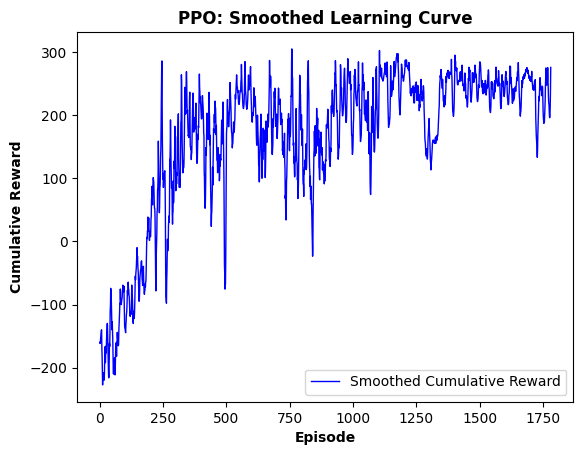

In [15]:
plot_learning_curve(model, rewards=callback.all_episode_rewards)

Finally, we can visualize the policy of our trained PPO agent, for fun.

In [ ]:
visualize_policy(model)